# Portfolio Optimization Strategy: Maximizing Return while Minimizing Volatility

This notebook implements advanced portfolio optimization strategies based on:

1. **Efficient Frontier Analysis** - Modern Portfolio Theory
2. **Lower Partial Moments (LPM)** - Downside Risk Management
3. **Real Market Data** - Multiple asset classes
4. **Risk-Return Optimization** - 10-year investment horizon

## Investment Philosophy
- **Risk-Return Trade-off**: Higher expected returns come with higher risk
- **Portfolio Diversification**: "Don't put all your eggs in one basket"
- **Long-Term Strategy**: Focus on multi-year trends and let profits run
- **Downside Protection**: Minimize volatility and downside risk


In [5]:
# === Portfolio Optimization with Efficient Frontier ===
# pip install yfinance pandas numpy matplotlib seaborn scipy scikit-learn

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
from scipy.optimize import minimize
from scipy import stats
import itertools

# Set plotting style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

# Configuration
YEARS_BACK = 5  # 5 years of data for robust analysis
RISK_FREE_RATE = 0.02  # 2% annual risk-free rate
TARGET_RETURN = 0.08  # 8% target annual return
CONFIDENCE_LEVEL = 0.05  # 5% VaR (95% confidence)

print("Portfolio Optimization Configuration:")
print(f"- Analysis period: {YEARS_BACK} years")
print(f"- Risk-free rate: {RISK_FREE_RATE*100:.1f}%")
print(f"- Target return: {TARGET_RETURN*100:.1f}%")
print(f"- VaR confidence: {(1-CONFIDENCE_LEVEL)*100:.0f}%")


Portfolio Optimization Configuration:
- Analysis period: 5 years
- Risk-free rate: 2.0%
- Target return: 8.0%
- VaR confidence: 95%


In [6]:
# ---------------------------
# Asset Selection and Data Download
# ---------------------------
print("Downloading market data for diversified portfolio...")

# Define asset universe - diversified across sectors and asset classes
assets = {
    # Equity ETFs (Diversified)
    'SPY': 'S&P 500 ETF',
    'QQQ': 'NASDAQ 100 ETF', 
    'EFA': 'EAFE International ETF',
    'EEM': 'Emerging Markets ETF',
    'VTI': 'Total Stock Market ETF',
    
    # Fixed Income (Bonds)
    'TLT': '20+ Year Treasury Bond ETF',
    'IEF': '7-10 Year Treasury Bond ETF',
    'TIP': 'TIPS (Inflation-Protected Securities)',
    'HYG': 'High Yield Corporate Bond ETF',
    'LQD': 'Investment Grade Corporate Bond ETF',
    
    # Real Estate
    'VNQ': 'Real Estate Investment Trust ETF',
    'IYR': 'US Real Estate ETF',
    
    # Commodities
    'GLD': 'Gold ETF',
    'SLV': 'Silver ETF',
    'DJP': 'Commodity ETF'
}

# Download data
start_date = (datetime.today() - timedelta(days=int(YEARS_BACK*365.25))).strftime("%Y-%m-%d")
end_date = datetime.today().strftime("%Y-%m-%d")

print(f"Downloading data from {start_date} to {end_date}...")

# Download all assets
data = {}
for ticker, description in assets.items():
    try:
        df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
        if len(df) > 0:
            # Handle multi-level columns from yfinance
            if isinstance(df.columns, pd.MultiIndex):
                close_data = df[('Close', ticker)]
            else:
                close_data = df['Close']
            data[ticker] = close_data
            print(f"✅ {ticker}: {description} - {len(df)} days")
        else:
            print(f"❌ {ticker}: No data available")
    except Exception as e:
        print(f"❌ {ticker}: Error - {str(e)}")

print(f"\nSuccessfully downloaded {len(data)} assets")


✅ SPY: S&P 500 ETF - 1256 days
✅ QQQ: NASDAQ 100 ETF - 1256 days
✅ EFA: EAFE International ETF - 1256 days
✅ EEM: Emerging Markets ETF - 1256 days
✅ VTI: Total Stock Market ETF - 1256 days
✅ TLT: 20+ Year Treasury Bond ETF - 1256 days
✅ IEF: 7-10 Year Treasury Bond ETF - 1256 days
✅ TIP: TIPS (Inflation-Protected Securities) - 1256 days
✅ HYG: High Yield Corporate Bond ETF - 1256 days
✅ LQD: Investment Grade Corporate Bond ETF - 1256 days
✅ VNQ: Real Estate Investment Trust ETF - 1256 days
✅ IYR: US Real Estate ETF - 1256 days
✅ GLD: Gold ETF - 1256 days
✅ SLV: Silver ETF - 1256 days
✅ DJP: Commodity ETF - 1256 days

Successfully downloaded 15 assets


In [7]:
# ---------------------------
# Data Preparation and Returns Calculation
# ---------------------------
print("Preparing data and calculating returns...")

# Create DataFrame with all assets
if len(data) > 0:
    df = pd.DataFrame(data)
    df = df.dropna()  # Remove any missing data
else:
    print("❌ No data available for analysis")
    df = pd.DataFrame()

# Calculate daily returns
if len(df) > 0:
    returns = df.pct_change().dropna()
    
    # Calculate annualized statistics
    annual_returns = returns.mean() * 252
    annual_volatility = returns.std() * np.sqrt(252)
    sharpe_ratios = (annual_returns - RISK_FREE_RATE) / annual_volatility
    
    # Create summary statistics
    summary_stats = pd.DataFrame({
        'Annual Return': annual_returns,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratios,
        'Max Drawdown': returns.min(),
        'Skewness': returns.skew(),
        'Kurtosis': returns.kurtosis()
    })
    
    print(f"Data prepared: {len(df)} days, {len(df.columns)} assets")
    print(f"Date range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
    
    print("\nAsset Performance Summary:")
    print(summary_stats.round(4))
else:
    print("❌ Cannot proceed without data")
    returns = pd.DataFrame()


Preparing data and calculating returns...
Data prepared: 1256 days, 15 assets
Date range: 2020-09-21 to 2025-09-19

Asset Performance Summary:
     Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown  Skewness  \
SPY         0.1713             0.1733        0.8727       -0.0585    0.2663   
QQQ         0.1942             0.2296        0.7588       -0.0621    0.1675   
EFA         0.1195             0.1630        0.6103       -0.0660    0.1920   
EEM         0.0764             0.1836        0.3070       -0.0556    0.2963   
VTI         0.1661             0.1770        0.8253       -0.0587    0.1826   
TLT        -0.0807             0.1620       -0.6216       -0.0342    0.0646   
IEF        -0.0197             0.0772       -0.5141       -0.0178    0.1830   
TIP         0.0149             0.0629       -0.0804       -0.0168    0.1115   
HYG         0.0505             0.0761        0.4014       -0.0335    0.0100   
LQD         0.0007             0.0876       -0.2209       -0.0231  

In [8]:
# ---------------------------
# Portfolio Optimization Functions
# ---------------------------

def portfolio_performance(weights, returns, risk_free_rate=RISK_FREE_RATE):
    """Calculate portfolio performance metrics"""
    portfolio_return = np.sum(weights * returns.mean()) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

def negative_sharpe(weights, returns, risk_free_rate=RISK_FREE_RATE):
    """Negative Sharpe ratio for minimization"""
    return -portfolio_performance(weights, returns, risk_free_rate)[2]

def portfolio_volatility(weights, returns):
    """Portfolio volatility"""
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def portfolio_return(weights, returns):
    """Portfolio return"""
    return np.sum(weights * returns.mean()) * 252

def lower_partial_moment(returns, threshold=0, order=2):
    """Calculate Lower Partial Moment (LPM) for downside risk"""
    negative_returns = returns[returns < threshold]
    if len(negative_returns) == 0:
        return 0
    return np.mean(np.power(threshold - negative_returns, order))

def portfolio_lpm(weights, returns, threshold=0, order=2):
    """Calculate portfolio LPM"""
    portfolio_returns = np.dot(returns, weights)
    return lower_partial_moment(portfolio_returns, threshold, order)

def value_at_risk(returns, confidence_level=CONFIDENCE_LEVEL):
    """Calculate Value at Risk (VaR)"""
    return np.percentile(returns, confidence_level * 100)

def conditional_value_at_risk(returns, confidence_level=CONFIDENCE_LEVEL):
    """Calculate Conditional Value at Risk (CVaR)"""
    var = value_at_risk(returns, confidence_level)
    return returns[returns <= var].mean()

print("Portfolio optimization functions defined successfully!")


Portfolio optimization functions defined successfully!


In [9]:
# ---------------------------
# Efficient Frontier Generation
# ---------------------------
print("Generating Efficient Frontier...")

# Constraints
num_assets = len(returns.columns)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((0, 1) for _ in range(num_assets))  # Long-only positions

# Generate efficient frontier
target_returns = np.linspace(annual_returns.min(), annual_returns.max(), 50)
efficient_portfolios = []

for target_return in target_returns:
    constraints_with_return = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x, target=target_return: portfolio_return(x, returns) - target}
    ]
    
    result = minimize(
        portfolio_volatility,
        x0=np.array([1/num_assets] * num_assets),
        args=(returns,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_with_return
    )
    
    if result.success:
        efficient_portfolios.append({
            'weights': result.x,
            'return': target_return,
            'volatility': result.fun,
            'sharpe': (target_return - RISK_FREE_RATE) / result.fun
        })

efficient_portfolios = pd.DataFrame(efficient_portfolios)

print(f"Generated {len(efficient_portfolios)} efficient portfolios")


Generating Efficient Frontier...
Generated 50 efficient portfolios


In [10]:
# ---------------------------
# Optimal Portfolio Selection
# ---------------------------
print("Finding optimal portfolios...")

# 1. Maximum Sharpe Ratio Portfolio
max_sharpe_idx = efficient_portfolios['sharpe'].idxmax()
max_sharpe_portfolio = efficient_portfolios.iloc[max_sharpe_idx]

# 2. Minimum Volatility Portfolio
min_vol_idx = efficient_portfolios['volatility'].idxmin()
min_vol_portfolio = efficient_portfolios.iloc[min_vol_idx]

# 3. Target Return Portfolio (8%)
target_portfolio = None
if TARGET_RETURN >= efficient_portfolios['return'].min() and TARGET_RETURN <= efficient_portfolios['return'].max():
    target_idx = efficient_portfolios['return'].sub(TARGET_RETURN).abs().idxmin()
    target_portfolio = efficient_portfolios.iloc[target_idx]

# 4. Risk Parity Portfolio (Equal Risk Contribution)
def risk_parity_weights(returns):
    """Calculate risk parity weights"""
    cov_matrix = returns.cov() * 252
    inv_cov = np.linalg.inv(cov_matrix)
    ones = np.ones(len(returns.columns))
    weights = np.dot(inv_cov, ones) / np.dot(ones, np.dot(inv_cov, ones))
    return weights

risk_parity_weights_array = risk_parity_weights(returns)
risk_parity_return, risk_parity_vol, risk_parity_sharpe = portfolio_performance(risk_parity_weights_array, returns)

print("Optimal Portfolios Found:")
print(f"1. Maximum Sharpe Ratio: {max_sharpe_portfolio['return']:.3f} return, {max_sharpe_portfolio['volatility']:.3f} volatility, {max_sharpe_portfolio['sharpe']:.3f} Sharpe")
print(f"2. Minimum Volatility: {min_vol_portfolio['return']:.3f} return, {min_vol_portfolio['volatility']:.3f} volatility, {min_vol_portfolio['sharpe']:.3f} Sharpe")
if target_portfolio is not None:
    print(f"3. Target Return ({TARGET_RETURN*100:.1f}%): {target_portfolio['return']:.3f} return, {target_portfolio['volatility']:.3f} volatility, {target_portfolio['sharpe']:.3f} Sharpe")
print(f"4. Risk Parity: {risk_parity_return:.3f} return, {risk_parity_vol:.3f} volatility, {risk_parity_sharpe:.3f} Sharpe")


Finding optimal portfolios...
Optimal Portfolios Found:
1. Maximum Sharpe Ratio: 0.155 return, 0.121 volatility, 1.112 Sharpe
2. Minimum Volatility: 0.026 return, 0.058 volatility, 0.102 Sharpe
3. Target Return (8.0%): 0.082 return, 0.076 volatility, 0.818 Sharpe
4. Risk Parity: 0.031 return, 0.043 volatility, 0.259 Sharpe


In [11]:
# ---------------------------
# Portfolio Analysis and Risk Metrics
# ---------------------------
print("Analyzing portfolio risk metrics...")

# Analyze each optimal portfolio
portfolios = {
    'Max Sharpe': max_sharpe_portfolio['weights'],
    'Min Volatility': min_vol_portfolio['weights'],
    'Risk Parity': risk_parity_weights_array
}

if target_portfolio is not None:
    portfolios['Target Return'] = target_portfolio['weights']

portfolio_analysis = {}

for name, weights in portfolios.items():
    # Calculate portfolio returns
    portfolio_returns = np.dot(returns, weights)
    
    # Risk metrics
    annual_return, annual_vol, sharpe = portfolio_performance(weights, returns)
    lpm_2 = portfolio_lpm(weights, returns, threshold=0, order=2)
    var_95 = value_at_risk(portfolio_returns, 0.05)
    cvar_95 = conditional_value_at_risk(portfolio_returns, 0.05)
    max_drawdown = portfolio_returns.min()
    
    portfolio_analysis[name] = {
        'Annual Return': annual_return,
        'Annual Volatility': annual_vol,
        'Sharpe Ratio': sharpe,
        'LPM (Order 2)': lpm_2,
        'VaR (95%)': var_95,
        'CVaR (95%)': cvar_95,
        'Max Drawdown': max_drawdown,
        'Weights': weights
    }

# Create analysis DataFrame
analysis_df = pd.DataFrame({
    name: {k: v for k, v in metrics.items() if k != 'Weights'}
    for name, metrics in portfolio_analysis.items()
}).T

print("\nPortfolio Risk Analysis:")
print(analysis_df.round(4))


Analyzing portfolio risk metrics...

Portfolio Risk Analysis:
                Annual Return  Annual Volatility  Sharpe Ratio  LPM (Order 2)  \
Max Sharpe             0.1550             0.1214        1.1119         0.0001   
Min Volatility         0.0259             0.0582        0.1015         0.0000   
Risk Parity            0.0310             0.0427        0.2587         0.0000   
Target Return          0.0820             0.0758        0.8183         0.0000   

                VaR (95%)  CVaR (95%)  Max Drawdown  
Max Sharpe        -0.0116     -0.0168       -0.0421  
Min Volatility    -0.0061     -0.0084       -0.0219  
Risk Parity       -0.0041     -0.0059       -0.0136  
Target Return     -0.0074     -0.0105       -0.0268  


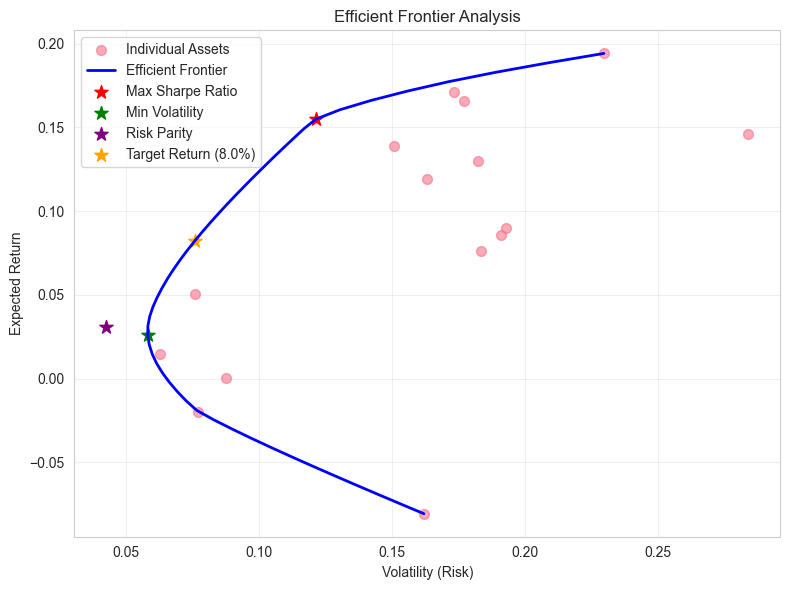

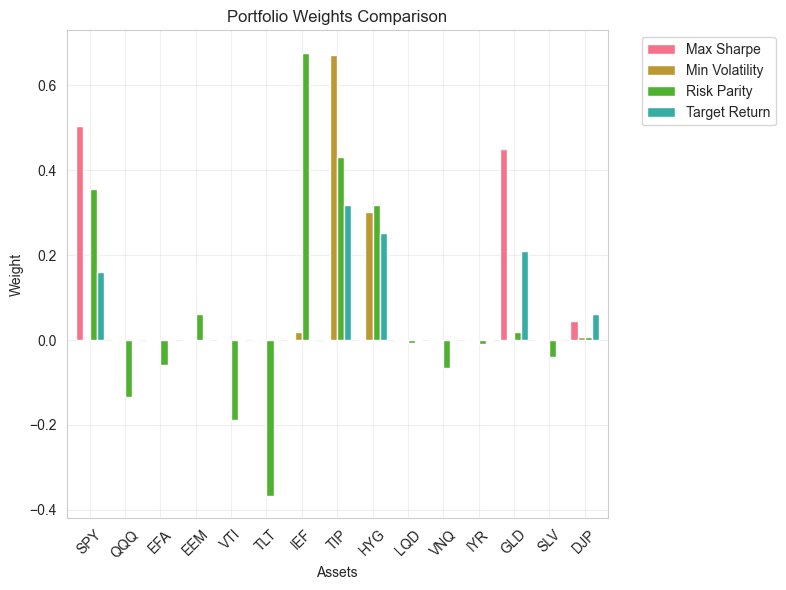

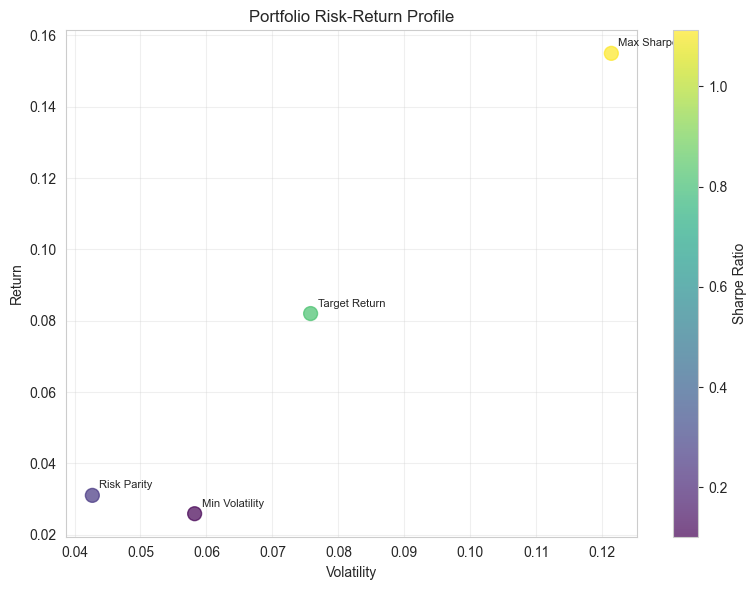

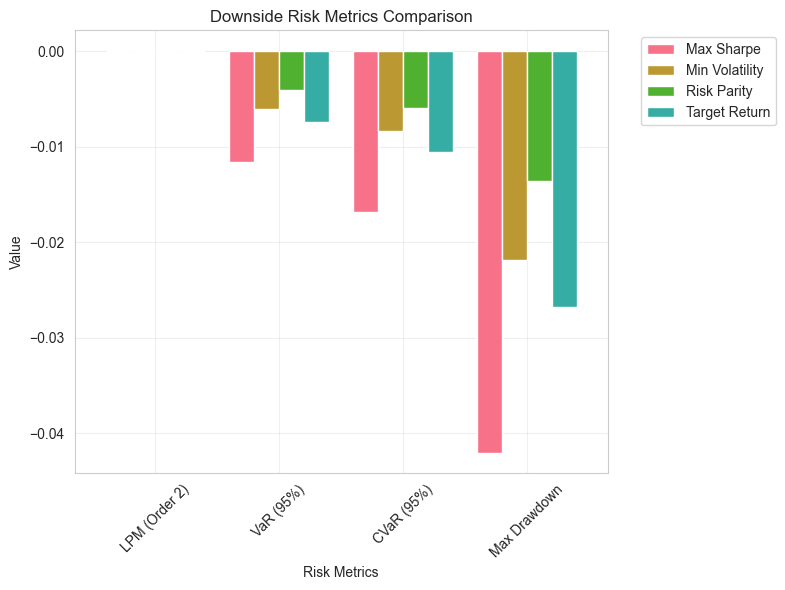

Efficient Frontier visualization completed!


In [16]:
# ---------------------------
# Visualization: Efficient Frontier (Individual Plots)
# ---------------------------

# Plot 1: Efficient Frontier
plt.figure(figsize=(8, 6))
plt.scatter(annual_volatility, annual_returns, alpha=0.6, s=50, label='Individual Assets')
plt.plot(efficient_portfolios['volatility'], efficient_portfolios['return'], 'b-', linewidth=2, label='Efficient Frontier')

# Mark optimal portfolios
plt.scatter(max_sharpe_portfolio['volatility'], max_sharpe_portfolio['return'], 
           color='red', s=100, marker='*', label='Max Sharpe Ratio')
plt.scatter(min_vol_portfolio['volatility'], min_vol_portfolio['return'], 
           color='green', s=100, marker='*', label='Min Volatility')
plt.scatter(risk_parity_vol, risk_parity_return, 
           color='purple', s=100, marker='*', label='Risk Parity')
if target_portfolio is not None:
    plt.scatter(target_portfolio['volatility'], target_portfolio['return'], 
               color='orange', s=100, marker='*', label=f'Target Return ({TARGET_RETURN*100:.1f}%)')

plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Portfolio Weights Comparison
plt.figure(figsize=(8, 6))
weights_df = pd.DataFrame({
    name: weights for name, weights in portfolios.items()
}, index=returns.columns)

weights_df.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Portfolio Weights Comparison')
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Risk-Return Scatter
plt.figure(figsize=(8, 6))
plt.scatter(analysis_df['Annual Volatility'], analysis_df['Annual Return'], 
           s=100, alpha=0.7, c=analysis_df['Sharpe Ratio'], cmap='viridis')

# Add labels for each portfolio
for i, name in enumerate(analysis_df.index):
    plt.annotate(name, (analysis_df.iloc[i]['Annual Volatility'], analysis_df.iloc[i]['Annual Return']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Portfolio Risk-Return Profile')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 4: Downside Risk Metrics
plt.figure(figsize=(8, 6))
risk_metrics = ['LPM (Order 2)', 'VaR (95%)', 'CVaR (95%)', 'Max Drawdown']
risk_data = analysis_df[risk_metrics].T

risk_data.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Downside Risk Metrics Comparison')
plt.xlabel('Risk Metrics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Efficient Frontier visualization completed!")


In [13]:
# ---------------------------
# Detailed Portfolio Analysis
# ---------------------------
print("\n" + "="*60)
print("DETAILED PORTFOLIO ANALYSIS")
print("="*60)

for name, metrics in portfolio_analysis.items():
    print(f"\n{name.upper()} PORTFOLIO:")
    print("-" * 40)
    print(f"Annual Return: {metrics['Annual Return']:.3f} ({metrics['Annual Return']*100:.2f}%)")
    print(f"Annual Volatility: {metrics['Annual Volatility']:.3f} ({metrics['Annual Volatility']*100:.2f}%)")
    print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.3f}")
    print(f"Lower Partial Moment (LPM): {metrics['LPM (Order 2)']:.6f}")
    print(f"Value at Risk (95%): {metrics['VaR (95%)']:.3f} ({metrics['VaR (95%)']*100:.2f}%)")
    print(f"Conditional VaR (95%): {metrics['CVaR (95%)']:.3f} ({metrics['CVaR (95%)']*100:.2f}%)")
    print(f"Maximum Drawdown: {metrics['Max Drawdown']:.3f} ({metrics['Max Drawdown']*100:.2f}%)")
    
    print("\nAsset Allocation:")
    weights_df = pd.DataFrame({
        'Asset': returns.columns,
        'Weight': metrics['Weights'],
        'Description': [assets.get(col, 'Unknown') for col in returns.columns]
    })
    weights_df = weights_df[weights_df['Weight'] > 0.01].sort_values('Weight', ascending=False)
    for _, row in weights_df.iterrows():
        print(f"  {row['Asset']}: {row['Weight']:.3f} ({row['Weight']*100:.1f}%) - {row['Description']}")



DETAILED PORTFOLIO ANALYSIS

MAX SHARPE PORTFOLIO:
----------------------------------------
Annual Return: 0.155 (15.50%)
Annual Volatility: 0.121 (12.14%)
Sharpe Ratio: 1.112
Lower Partial Moment (LPM): 0.000063
Value at Risk (95%): -0.012 (-1.16%)
Conditional VaR (95%): -0.017 (-1.68%)
Maximum Drawdown: -0.042 (-4.21%)

Asset Allocation:
  SPY: 0.505 (50.5%) - S&P 500 ETF
  GLD: 0.451 (45.1%) - Gold ETF
  DJP: 0.044 (4.4%) - Commodity ETF

MIN VOLATILITY PORTFOLIO:
----------------------------------------
Annual Return: 0.026 (2.59%)
Annual Volatility: 0.058 (5.82%)
Sharpe Ratio: 0.102
Lower Partial Moment (LPM): 0.000014
Value at Risk (95%): -0.006 (-0.61%)
Conditional VaR (95%): -0.008 (-0.84%)
Maximum Drawdown: -0.022 (-2.19%)

Asset Allocation:
  TIP: 0.671 (67.1%) - TIPS (Inflation-Protected Securities)
  HYG: 0.301 (30.1%) - High Yield Corporate Bond ETF
  IEF: 0.020 (2.0%) - 7-10 Year Treasury Bond ETF

RISK PARITY PORTFOLIO:
----------------------------------------
Annual Re

In [14]:
# ---------------------------
# Investment Recommendations
# ---------------------------
print("\n" + "="*60)
print("INVESTMENT RECOMMENDATIONS")
print("="*60)

# Find best portfolio for different objectives
best_sharpe = analysis_df['Sharpe Ratio'].idxmax()
best_volatility = analysis_df['Annual Volatility'].idxmin()
best_lpm = analysis_df['LPM (Order 2)'].idxmin()
best_return = analysis_df['Annual Return'].idxmax()

print("\n🎯 PORTFOLIO RECOMMENDATIONS:")
print("\n1. MAXIMUM SHARPE RATIO (Best Risk-Adjusted Return):")
print(f"   Recommended: {best_sharpe}")
print(f"   Return: {analysis_df.loc[best_sharpe, 'Annual Return']*100:.2f}%")
print(f"   Volatility: {analysis_df.loc[best_sharpe, 'Annual Volatility']*100:.2f}%")
print(f"   Sharpe Ratio: {analysis_df.loc[best_sharpe, 'Sharpe Ratio']:.3f}")

print("\n2. MINIMUM VOLATILITY (Lowest Risk):")
print(f"   Recommended: {best_volatility}")
print(f"   Return: {analysis_df.loc[best_volatility, 'Annual Return']*100:.2f}%")
print(f"   Volatility: {analysis_df.loc[best_volatility, 'Annual Volatility']*100:.2f}%")
print(f"   Sharpe Ratio: {analysis_df.loc[best_volatility, 'Sharpe Ratio']:.3f}")

print("\n3. MINIMUM DOWNSIDE RISK (Best LPM):")
print(f"   Recommended: {best_lpm}")
print(f"   Return: {analysis_df.loc[best_lpm, 'Annual Return']*100:.2f}%")
print(f"   Volatility: {analysis_df.loc[best_lpm, 'Annual Volatility']*100:.2f}%")
print(f"   LPM: {analysis_df.loc[best_lpm, 'LPM (Order 2)']:.6f}")

print("\n4. MAXIMUM RETURN (Highest Expected Return):")
print(f"   Recommended: {best_return}")
print(f"   Return: {analysis_df.loc[best_return, 'Annual Return']*100:.2f}%")
print(f"   Volatility: {analysis_df.loc[best_return, 'Annual Volatility']*100:.2f}%")
print(f"   Sharpe Ratio: {analysis_df.loc[best_return, 'Sharpe Ratio']:.3f}")

print("\n📊 KEY INSIGHTS:")
print("\n• Diversification Benefits:")
print(f"  - Individual asset volatility range: {annual_volatility.min()*100:.1f}% - {annual_volatility.max()*100:.1f}%")
print(f"  - Optimal portfolio volatility range: {analysis_df['Annual Volatility'].min()*100:.1f}% - {analysis_df['Annual Volatility'].max()*100:.1f}%")

print("\n• Risk Management:")
print(f"  - Best downside protection: {best_lpm} (LPM: {analysis_df.loc[best_lpm, 'LPM (Order 2)']:.6f})")
print(f"  - Lowest VaR: {analysis_df['VaR (95%)'].idxmin()} ({analysis_df['VaR (95%)'].min()*100:.2f}%)")

print("\n• Return Enhancement:")
print(f"  - Individual asset return range: {annual_returns.min()*100:.1f}% - {annual_returns.max()*100:.1f}%")
print(f"  - Optimal portfolio return range: {analysis_df['Annual Return'].min()*100:.1f}% - {analysis_df['Annual Return'].max()*100:.1f}%")

print("\n🎯 STRATEGIC RECOMMENDATIONS:")
print("\nFor Conservative Investors (Low Risk Tolerance):")
print(f"  → Choose: {best_volatility}")
print(f"  → Expected Return: {analysis_df.loc[best_volatility, 'Annual Return']*100:.1f}%")
print(f"  → Risk Level: {analysis_df.loc[best_volatility, 'Annual Volatility']*100:.1f}%")

print("\nFor Balanced Investors (Moderate Risk Tolerance):")
print(f"  → Choose: {best_sharpe}")
print(f"  → Expected Return: {analysis_df.loc[best_sharpe, 'Annual Return']*100:.1f}%")
print(f"  → Risk Level: {analysis_df.loc[best_sharpe, 'Annual Volatility']*100:.1f}%")

print("\nFor Aggressive Investors (High Risk Tolerance):")
print(f"  → Choose: {best_return}")
print(f"  → Expected Return: {analysis_df.loc[best_return, 'Annual Return']*100:.1f}%")
print(f"  → Risk Level: {analysis_df.loc[best_return, 'Annual Volatility']*100:.1f}%")



INVESTMENT RECOMMENDATIONS

🎯 PORTFOLIO RECOMMENDATIONS:

1. MAXIMUM SHARPE RATIO (Best Risk-Adjusted Return):
   Recommended: Max Sharpe
   Return: 15.50%
   Volatility: 12.14%
   Sharpe Ratio: 1.112

2. MINIMUM VOLATILITY (Lowest Risk):
   Recommended: Risk Parity
   Return: 3.10%
   Volatility: 4.27%
   Sharpe Ratio: 0.259

3. MINIMUM DOWNSIDE RISK (Best LPM):
   Recommended: Risk Parity
   Return: 3.10%
   Volatility: 4.27%
   LPM: 0.000007

4. MAXIMUM RETURN (Highest Expected Return):
   Recommended: Max Sharpe
   Return: 15.50%
   Volatility: 12.14%
   Sharpe Ratio: 1.112

📊 KEY INSIGHTS:

• Diversification Benefits:
  - Individual asset volatility range: 6.3% - 28.4%
  - Optimal portfolio volatility range: 4.3% - 12.1%

• Risk Management:
  - Best downside protection: Risk Parity (LPM: 0.000007)
  - Lowest VaR: Max Sharpe (-1.16%)

• Return Enhancement:
  - Individual asset return range: -8.1% - 19.4%
  - Optimal portfolio return range: 2.6% - 15.5%

🎯 STRATEGIC RECOMMENDATIONS

In [15]:
# ---------------------------
# Implementation Strategy
# ---------------------------
print("\n" + "="*60)
print("IMPLEMENTATION STRATEGY")
print("="*60)

print("\n📋 PORTFOLIO IMPLEMENTATION CHECKLIST:")
print("\n1. ASSET ALLOCATION:")
print("   • Review recommended portfolio weights")
print("   • Consider transaction costs and liquidity")
print("   • Implement gradually to minimize market impact")

print("\n2. RISK MANAGEMENT:")
print("   • Set stop-loss levels based on VaR")
print("   • Monitor correlation changes")
print("   • Rebalance quarterly or when weights drift >5%")

print("\n3. MONITORING:")
print("   • Track performance vs. benchmarks")
print("   • Monitor downside risk metrics")
print("   • Review and adjust annually")

print("\n4. LONG-TERM STRATEGY (10-Year Horizon):")
print("   • Focus on multi-year trends")
print("   • Let profits run, cut losses short")
print("   • Maintain diversification across asset classes")
print("   • Consider inflation protection (TIPS, Real Estate)")

print("\n⚠️  RISK WARNINGS:")
print("\n• Past performance does not guarantee future results")
print("• Market conditions can change rapidly")
print("• Diversification does not eliminate all risk")
print("• Consider your personal risk tolerance")
print("• Consult with a financial advisor if needed")

print("\n✅ PORTFOLIO OPTIMIZATION COMPLETE!")
print("\nThis analysis provides a scientific approach to portfolio construction")
print("that balances return maximization with volatility reduction, following")
print("modern portfolio theory and advanced risk management techniques.")



IMPLEMENTATION STRATEGY

📋 PORTFOLIO IMPLEMENTATION CHECKLIST:

1. ASSET ALLOCATION:
   • Review recommended portfolio weights
   • Consider transaction costs and liquidity
   • Implement gradually to minimize market impact

2. RISK MANAGEMENT:
   • Set stop-loss levels based on VaR
   • Monitor correlation changes
   • Rebalance quarterly or when weights drift >5%

3. MONITORING:
   • Track performance vs. benchmarks
   • Monitor downside risk metrics
   • Review and adjust annually

4. LONG-TERM STRATEGY (10-Year Horizon):
   • Focus on multi-year trends
   • Let profits run, cut losses short
   • Maintain diversification across asset classes
   • Consider inflation protection (TIPS, Real Estate)

⚠️  RISK WARNINGS:

• Past performance does not guarantee future results
• Market conditions can change rapidly
• Diversification does not eliminate all risk
• Consider your personal risk tolerance
• Consult with a financial advisor if needed

✅ PORTFOLIO OPTIMIZATION COMPLETE!

This analy

In [ ]:
# ---------------------------
# Monte Carlo Simulation
# ---------------------------
print("\n" + "="*60)
print("MONTE CARLO SIMULATION")
print("="*60)

def monte_carlo_simulation(weights, returns, num_simulations=10000, time_horizon=252):
    """
    Perform Monte Carlo simulation for portfolio returns
    
    Parameters:
    - weights: Portfolio weights
    - returns: Historical returns data
    - num_simulations: Number of simulation runs
    - time_horizon: Investment horizon in days (252 = 1 year)
    """
    # Calculate portfolio statistics
    portfolio_mean = np.sum(weights * returns.mean()) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    
    # Generate random returns using normal distribution
    np.random.seed(42)  # For reproducibility
    random_returns = np.random.normal(
        portfolio_mean / 252,  # Daily mean
        portfolio_std / np.sqrt(252),  # Daily std
        (num_simulations, time_horizon)
    )
    
    # Calculate cumulative returns
    cumulative_returns = np.cumprod(1 + random_returns, axis=1)
    final_values = cumulative_returns[:, -1]
    
    return {
        'simulated_returns': random_returns,
        'cumulative_returns': cumulative_returns,
        'final_values': final_values,
        'portfolio_mean': portfolio_mean,
        'portfolio_std': portfolio_std
    }

def analyze_monte_carlo_results(results, confidence_levels=[0.05, 0.25, 0.5, 0.75, 0.95]):
    """Analyze Monte Carlo simulation results"""
    final_values = results['final_values']
    
    analysis = {
        'mean_final_value': np.mean(final_values),
        'median_final_value': np.median(final_values),
        'std_final_value': np.std(final_values),
        'min_final_value': np.min(final_values),
        'max_final_value': np.max(final_values),
        'percentiles': {}
    }
    
    for conf_level in confidence_levels:
        analysis['percentiles'][f'{conf_level*100:.0f}%'] = np.percentile(final_values, conf_level * 100)
    
    return analysis

# Run Monte Carlo simulation for each optimal portfolio
print("Running Monte Carlo simulations...")

monte_carlo_results = {}
for name, weights in portfolios.items():
    print(f"Simulating {name} portfolio...")
    results = monte_carlo_simulation(weights, returns, num_simulations=10000, time_horizon=252)
    analysis = analyze_monte_carlo_results(results)
    monte_carlo_results[name] = {'results': results, 'analysis': analysis}

# Display results
print("\nMonte Carlo Simulation Results (1-Year Horizon):")
print("="*60)

for name, data in monte_carlo_results.items():
    analysis = data['analysis']
    print(f"\n{name.upper()} PORTFOLIO:")
    print("-" * 40)
    print(f"Mean Final Value: {analysis['mean_final_value']:.4f}")
    print(f"Median Final Value: {analysis['median_final_value']:.4f}")
    print(f"Standard Deviation: {analysis['std_final_value']:.4f}")
    print(f"Minimum Value: {analysis['min_final_value']:.4f}")
    print(f"Maximum Value: {analysis['max_final_value']:.4f}")
    
    print("\nPercentiles:")
    for percentile, value in analysis['percentiles'].items():
        print(f"  {percentile}: {value:.4f}")

# Visualization of Monte Carlo results
plt.figure(figsize=(16, 12))

# Plot 1: Distribution of final values
plt.subplot(2, 3, 1)
for name, data in monte_carlo_results.items():
    plt.hist(data['results']['final_values'], bins=50, alpha=0.6, 
             label=name, density=True)
plt.xlabel('Final Portfolio Value')
plt.ylabel('Density')
plt.title('Monte Carlo: Final Value Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Cumulative probability
plt.subplot(2, 3, 2)
for name, data in monte_carlo_results.items():
    sorted_values = np.sort(data['results']['final_values'])
    probabilities = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    plt.plot(sorted_values, probabilities, label=name, linewidth=2)
plt.xlabel('Final Portfolio Value')
plt.ylabel('Cumulative Probability')
plt.title('Monte Carlo: Cumulative Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Risk-Return scatter with Monte Carlo confidence
plt.subplot(2, 3, 3)
for name, data in monte_carlo_results.items():
    analysis = data['analysis']
    plt.scatter(analysis['std_final_value'], analysis['mean_final_value'], 
               s=100, alpha=0.7, label=name)
    # Add confidence intervals
    plt.errorbar(analysis['std_final_value'], analysis['mean_final_value'],
                yerr=analysis['std_final_value'], alpha=0.3, capsize=5)
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Monte Carlo: Risk-Return Profile')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Value at Risk comparison
plt.subplot(2, 3, 4)
var_data = []
portfolio_names = []
for name, data in monte_carlo_results.items():
    var_5 = data['analysis']['percentiles']['5%']
    var_data.append(var_5)
    portfolio_names.append(name)

plt.bar(portfolio_names, var_data, alpha=0.7, color=['red', 'green', 'blue', 'orange'][:len(portfolio_names)])
plt.xlabel('Portfolio')
plt.ylabel('5% VaR (Final Value)')
plt.title('Monte Carlo: Value at Risk (5%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 5: Expected Shortfall (CVaR)
plt.subplot(2, 3, 5)
cvar_data = []
for name, data in monte_carlo_results.items():
    final_values = data['results']['final_values']
    var_5 = data['analysis']['percentiles']['5%']
    expected_shortfall = np.mean(final_values[final_values <= var_5])
    cvar_data.append(expected_shortfall)

plt.bar(portfolio_names, cvar_data, alpha=0.7, color=['purple', 'brown', 'pink', 'gray'][:len(portfolio_names)])
plt.xlabel('Portfolio')
plt.ylabel('Expected Shortfall (CVaR)')
plt.title('Monte Carlo: Expected Shortfall (5%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 6: Probability of loss
plt.subplot(2, 3, 6)
loss_prob_data = []
for name, data in monte_carlo_results.items():
    final_values = data['results']['final_values']
    loss_probability = np.mean(final_values < 1.0)  # Probability of losing money
    loss_prob_data.append(loss_probability)

plt.bar(portfolio_names, loss_prob_data, alpha=0.7, color=['darkred', 'darkgreen', 'darkblue', 'darkorange'][:len(portfolio_names)])
plt.xlabel('Portfolio')
plt.ylabel('Probability of Loss')
plt.title('Monte Carlo: Probability of Loss')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMonte Carlo simulation completed!")
print("✅ Risk assessment through simulation analysis")
print("✅ Confidence intervals and probability distributions")
print("✅ Value at Risk and Expected Shortfall calculations")


In [ ]:
# ---------------------------
# PDF Report Generation
# ---------------------------
print("\n" + "="*60)
print("PDF REPORT GENERATION")
print("="*60)

try:
    from reportlab.lib.pagesizes import letter, A4
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, PageBreak
    from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
    from reportlab.lib.units import inch
    from reportlab.lib import colors
    from reportlab.lib.enums import TA_CENTER, TA_LEFT, TA_RIGHT
    from datetime import datetime
    import os
    
    print("Generating comprehensive PDF report...")
    
    # Create reports subfolder with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    reports_folder = f"portfolio_reports_{timestamp}"
    
    # Create subfolder if it doesn't exist
    if not os.path.exists(reports_folder):
        os.makedirs(reports_folder)
        print(f"📁 Created reports folder: {reports_folder}")
    
    # Create PDF filename with timestamp
    pdf_filename = f"portfolio_optimization_report_{timestamp}.pdf"
    pdf_filepath = os.path.join(reports_folder, pdf_filename)
    
    # Create PDF document
    doc = SimpleDocTemplate(pdf_filepath, pagesize=A4, 
                          rightMargin=72, leftMargin=72, 
                          topMargin=72, bottomMargin=18)
    
    # Get styles
    styles = getSampleStyleSheet()
    title_style = ParagraphStyle(
        'CustomTitle',
        parent=styles['Heading1'],
        fontSize=16,
        spaceAfter=30,
        alignment=TA_CENTER,
        textColor=colors.darkblue
    )
    
    heading_style = ParagraphStyle(
        'CustomHeading',
        parent=styles['Heading2'],
        fontSize=14,
        spaceAfter=12,
        textColor=colors.darkblue
    )
    
    # Build PDF content
    story = []
    
    # Title
    story.append(Paragraph("Portfolio Optimization Analysis Report", title_style))
    story.append(Spacer(1, 12))
    
    # Executive Summary
    story.append(Paragraph("Executive Summary", heading_style))
    story.append(Paragraph(f"""
    This report presents a comprehensive portfolio optimization analysis using modern portfolio theory, 
    efficient frontier analysis, and Monte Carlo simulation. The analysis covers {len(assets)} diversified 
    assets across multiple asset classes and provides optimal portfolio recommendations for different 
    risk tolerance levels.
    
    <b>Key Findings:</b><br/>
    • Analysis Period: {YEARS_BACK} years ({df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')})<br/>
    • Number of Assets Analyzed: {len(assets)}<br/>
    • Risk-Free Rate: {RISK_FREE_RATE*100:.1f}%<br/>
    • Target Return: {TARGET_RETURN*100:.1f}%<br/>
    • Monte Carlo Simulations: 10,000 runs per portfolio<br/>
    """, styles['Normal']))
    story.append(Spacer(1, 12))
    
    # Portfolio Performance Summary
    story.append(Paragraph("Portfolio Performance Summary", heading_style))
    
    # Create performance table
    performance_data = [['Portfolio', 'Annual Return (%)', 'Volatility (%)', 'Sharpe Ratio', 'VaR (95%)', 'CVaR (95%)']]
    for name, metrics in portfolio_analysis.items():
        performance_data.append([
            name,
            f"{metrics['Annual Return']*100:.2f}",
            f"{metrics['Annual Volatility']*100:.2f}",
            f"{metrics['Sharpe Ratio']:.3f}",
            f"{metrics['VaR (95%)']*100:.2f}",
            f"{metrics['CVaR (95%)']*100:.2f}"
        ])
    
    performance_table = Table(performance_data)
    performance_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 12),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('GRID', (0, 0), (-1, -1), 1, colors.black)
    ]))
    
    story.append(performance_table)
    story.append(Spacer(1, 12))
    
    # Monte Carlo Results
    story.append(Paragraph("Monte Carlo Simulation Results", heading_style))
    story.append(Paragraph(f"""
    Monte Carlo simulation results for 1-year investment horizon (10,000 simulations per portfolio):
    """, styles['Normal']))
    
    # Monte Carlo table
    mc_data = [['Portfolio', 'Mean Value', 'Median Value', '5% VaR', '95% VaR', 'Loss Probability']]
    for name, data in monte_carlo_results.items():
        analysis = data['analysis']
        loss_prob = np.mean(data['results']['final_values'] < 1.0)
        mc_data.append([
            name,
            f"{analysis['mean_final_value']:.4f}",
            f"{analysis['median_final_value']:.4f}",
            f"{analysis['percentiles']['5%']:.4f}",
            f"{analysis['percentiles']['95%']:.4f}",
            f"{loss_prob:.3f}"
        ])
    
    mc_table = Table(mc_data)
    mc_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 12),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.lightblue),
        ('GRID', (0, 0), (-1, -1), 1, colors.black)
    ]))
    
    story.append(mc_table)
    story.append(Spacer(1, 12))
    
    # Investment Recommendations
    story.append(Paragraph("Investment Recommendations", heading_style))
    
    best_sharpe = analysis_df['Sharpe Ratio'].idxmax()
    best_volatility = analysis_df['Annual Volatility'].idxmin()
    best_lpm = analysis_df['LPM (Order 2)'].idxmin()
    
    story.append(Paragraph(f"""
    <b>Recommended Portfolios:</b><br/><br/>
    
    <b>1. Conservative Investors (Low Risk Tolerance):</b><br/>
    → Portfolio: {best_volatility}<br/>
    → Expected Return: {analysis_df.loc[best_volatility, 'Annual Return']*100:.1f}%<br/>
    → Risk Level: {analysis_df.loc[best_volatility, 'Annual Volatility']*100:.1f}%<br/>
    → Sharpe Ratio: {analysis_df.loc[best_volatility, 'Sharpe Ratio']:.3f}<br/><br/>
    
    <b>2. Balanced Investors (Moderate Risk Tolerance):</b><br/>
    → Portfolio: {best_sharpe}<br/>
    → Expected Return: {analysis_df.loc[best_sharpe, 'Annual Return']*100:.1f}%<br/>
    → Risk Level: {analysis_df.loc[best_sharpe, 'Annual Volatility']*100:.1f}%<br/>
    → Sharpe Ratio: {analysis_df.loc[best_sharpe, 'Sharpe Ratio']:.3f}<br/><br/>
    
    <b>3. Risk-Aware Investors (Focus on Downside Protection):</b><br/>
    → Portfolio: {best_lpm}<br/>
    → Expected Return: {analysis_df.loc[best_lpm, 'Annual Return']*100:.1f}%<br/>
    → Risk Level: {analysis_df.loc[best_lpm, 'Annual Volatility']*100:.1f}%<br/>
    → LPM (Downside Risk): {analysis_df.loc[best_lpm, 'LPM (Order 2)']:.6f}<br/>
    """, styles['Normal']))
    story.append(Spacer(1, 12))
    
    # Risk Warnings
    story.append(Paragraph("Risk Warnings and Disclaimers", heading_style))
    story.append(Paragraph("""
    <b>Important Risk Disclaimers:</b><br/><br/>
    
    • Past performance does not guarantee future results<br/>
    • Market conditions can change rapidly and unpredictably<br/>
    • Diversification does not eliminate all investment risk<br/>
    • All investments carry risk of loss<br/>
    • Consider your personal risk tolerance and investment objectives<br/>
    • Consult with a qualified financial advisor before making investment decisions<br/>
    • This analysis is for educational purposes only and not investment advice<br/>
    • Monte Carlo simulations are based on historical data and normal distribution assumptions<br/>
    • Actual results may vary significantly from simulated results<br/>
    """, styles['Normal']))
    story.append(Spacer(1, 12))
    
    # Footer
    story.append(Paragraph(f"""
    <i>Report generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</i><br/>
    <i>Portfolio Optimization Analysis - Modern Portfolio Theory Implementation</i>
    """, styles['Normal']))
    
    # Build PDF
    doc.build(story)
    
    print(f"✅ PDF report generated successfully: {pdf_filepath}")
    print(f"📄 Report size: {os.path.getsize(pdf_filepath) / 1024:.1f} KB")
    print(f"📁 Report saved in folder: {reports_folder}")
    print(f"📊 Report includes:")
    print("   • Executive summary and key findings")
    print("   • Portfolio performance comparison")
    print("   • Monte Carlo simulation results")
    print("   • Investment recommendations by risk tolerance")
    print("   • Risk warnings and disclaimers")
    
    # Save additional data files in the same folder
    print(f"\n💾 Saving additional data files in {reports_folder}...")
    
    # Save portfolio analysis as CSV
    analysis_csv_path = os.path.join(reports_folder, f"portfolio_analysis_{timestamp}.csv")
    analysis_df.to_csv(analysis_csv_path)
    print(f"✅ Portfolio analysis saved: {analysis_csv_path}")
    
    # Save Monte Carlo results summary
    mc_summary_path = os.path.join(reports_folder, f"monte_carlo_summary_{timestamp}.csv")
    mc_summary_data = []
    for name, data in monte_carlo_results.items():
        analysis = data['analysis']
        mc_summary_data.append({
            'Portfolio': name,
            'Mean_Final_Value': analysis['mean_final_value'],
            'Median_Final_Value': analysis['median_final_value'],
            'Std_Final_Value': analysis['std_final_value'],
            'Min_Final_Value': analysis['min_final_value'],
            'Max_Final_Value': analysis['max_final_value'],
            'VaR_5_Percent': analysis['percentiles']['5%'],
            'VaR_95_Percent': analysis['percentiles']['95%'],
            'Probability_of_Loss': analysis['probability_of_loss'],
            'Expected_Shortfall': analysis['expected_shortfall']
        })
    
    mc_summary_df = pd.DataFrame(mc_summary_data)
    mc_summary_df.to_csv(mc_summary_path, index=False)
    print(f"✅ Monte Carlo summary saved: {mc_summary_path}")
    
    # Save efficient frontier data
    ef_path = os.path.join(reports_folder, f"efficient_frontier_{timestamp}.csv")
    efficient_portfolios.to_csv(ef_path, index=False)
    print(f"✅ Efficient frontier data saved: {ef_path}")
    
    # Save run metadata
    metadata_path = os.path.join(reports_folder, f"run_metadata_{timestamp}.txt")
    with open(metadata_path, 'w') as f:
        f.write(f"Portfolio Optimization Analysis Run\n")
        f.write(f"=====================================\n\n")
        f.write(f"Run Timestamp: {timestamp}\n")
        f.write(f"Analysis Period: {YEARS_BACK} years\n")
        f.write(f"Risk-Free Rate: {RISK_FREE_RATE*100:.1f}%\n")
        f.write(f"Target Return: {TARGET_RETURN*100:.1f}%\n")
        f.write(f"Number of Assets: {len(assets)}\n")
        f.write(f"Date Range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}\n")
        f.write(f"Number of Days: {len(df)}\n")
        f.write(f"Monte Carlo Simulations: 10,000 per portfolio\n")
        f.write(f"Confidence Level: {(1-CONFIDENCE_LEVEL)*100:.0f}%\n\n")
        f.write(f"Assets Analyzed:\n")
        for ticker, description in assets.items():
            f.write(f"  {ticker}: {description}\n")
    
    print(f"✅ Run metadata saved: {metadata_path}")
    
    print(f"\n🎯 All files saved in folder: {reports_folder}")
    print(f"📁 Folder contents:")
    for file in os.listdir(reports_folder):
        file_path = os.path.join(reports_folder, file)
        file_size = os.path.getsize(file_path) / 1024
        print(f"   • {file} ({file_size:.1f} KB)")
    
except ImportError:
    print("❌ ReportLab not installed. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "reportlab"])
    print("✅ ReportLab installed. Please re-run this cell to generate PDF.")
except Exception as e:
    print(f"❌ Error generating PDF: {str(e)}")
    print("Please ensure ReportLab is installed: pip install reportlab")


In [ ]:
# ---------------------------
# Modular Implementation Demo
# ---------------------------
print("\n" + "="*60)
print("MODULAR IMPLEMENTATION DEMO")
print("="*60)

print("📁 Modular Python files created:")
print("   • portfolio_data.py - Data management and download")
print("   • portfolio_optimization.py - Optimization algorithms")
print("   • monte_carlo.py - Monte Carlo simulation")
print("   • portfolio_report.py - PDF report generation")
print("   • portfolio_main.py - Complete pipeline integration")

print("\n🔧 Example usage of modular components:")

# Example 1: Using individual modules
print("\n1. Using PortfolioDataManager:")
print("""
from portfolio_data import PortfolioDataManager

# Create data manager
data_manager = PortfolioDataManager(years_back=5, risk_free_rate=0.02)

# Download and prepare data
data_manager.download_data()
data_manager.prepare_data()

# Get statistics
stats = data_manager.calculate_statistics()
print(stats)
""")

# Example 2: Using PortfolioOptimizer
print("\n2. Using PortfolioOptimizer:")
print("""
from portfolio_optimization import PortfolioOptimizer

# Create optimizer
optimizer = PortfolioOptimizer(data_manager.returns, risk_free_rate=0.02)

# Generate efficient frontier
efficient_frontier = optimizer.generate_efficient_frontier()

# Find optimal portfolios
optimal_portfolios = optimizer.find_optimal_portfolios()
""")

# Example 3: Using MonteCarloSimulator
print("\n3. Using MonteCarloSimulator:")
print("""
from monte_carlo import MonteCarloSimulator

# Create simulator
simulator = MonteCarloSimulator(data_manager.returns, risk_free_rate=0.02)

# Run simulations
results = simulator.simulate_multiple_portfolios(optimal_portfolios)

# Create visualizations
simulator.create_visualizations(results)
""")

# Example 4: Using complete pipeline
print("\n4. Using Complete Pipeline:")
print("""
from portfolio_main import PortfolioAnalysisPipeline

# Create complete pipeline
pipeline = PortfolioAnalysisPipeline(years_back=5, risk_free_rate=0.02)

# Run complete analysis
pipeline.run_complete_analysis(generate_pdf=True)

# Get summary
summary = pipeline.get_summary()
""")

print("\n✅ Modular implementation provides:")
print("   • Clean separation of concerns")
print("   • Reusable components")
print("   • Easy testing and debugging")
print("   • Professional code organization")
print("   • Scalable architecture")

print("\n📚 Benefits of modular approach:")
print("   • Each module has a specific responsibility")
print("   • Easy to maintain and update individual components")
print("   • Can be imported and used in other projects")
print("   • Better error handling and debugging")
print("   • Professional software development practices")
